In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import itertools as itertools
from operator import add, neg
import nashpy as nash
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import random
import scipy.stats as scp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
"""tab1 =pd.read_csv("df_0104_70_9.csv") 
tab2 =pd.read_csv("df_0104_70_10.csv") 
tab3 =pd.read_csv("df_0104_70_3.csv") 
tab4 =pd.read_csv("df_0104_70_4.csv") 
tab5 =pd.read_csv("df_0104_70_5.csv") 
tab6 =pd.read_csv("df_0104_70_6.csv") 
tab7 =pd.read_csv("df_0104_70_7.csv") 
tab8 =pd.read_csv("df_0104_70_8.csv") 

Bigtabdf=pd.concat([tab1, tab2, tab3, tab4,
              tab5, tab6, tab7, tab8])

Bigtabdf=Bigtabdf.reset_index()
Bigtabdf=Bigtabdf.drop(['index'], 1)
Bigtabdf=Bigtabdf.drop(['Unnamed: 0'], 1)
Bigtabdf.to_csv('df_0104_FULL_'+'.csv')
"""

Bigtabdf =pd.read_csv("df_0104_FULL_.csv") 

C:\Users\PaulWork\AppData\Local\Temp/ipykernel_44800/46227244.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Bigtabdf=Bigtabdf.drop(['index'], 1)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_44800/46227244.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Bigtabdf=Bigtabdf.drop(['Unnamed: 0'], 1)


In [3]:
def prepare(A):
    A=np.insert(A,A.shape[1],np.repeat(1,A.shape[0]),axis=1)
    A=np.insert(A,A.shape[0],np.array([-1 for k in range(A.shape[1]-1)]+[0]),axis=0)
    return(A)

def find_pivot(A):
    # Select Column
    i=0
    col_piv=-1
    while i< A.shape[1]-1:
        if A[A.shape[0]-1,i]<0:
            col_piv=i
            break
        i+=1 
    if col_piv==-1:
        return[-100,-100]
        
    # Select Row
    R=[]
    for k in range(A.shape[0]-1):
        ratio=5000
        if A[k,col_piv]!=0:
            ratio=A[k,A.shape[1]-1]/A[k,col_piv]
        R+=[ratio]
        
    arr=np.array(R)
    sort_idx=np.argsort(arr)
    j=0
    row_piv=sort_idx[0]
    while A[int(row_piv), col_piv] <=0:
        row_piv=sort_idx[j]
        j+=1
        
        if j>=A.shape[0]:
            return([-100,-100])
    return row_piv, col_piv 


def pivot_transform(p,r,c,q):
    return np.array([[1/p,r/p],[-c/p,q-r*c/p]])

def pivot(row,col,mat):
    B=np.copy(mat)
    B[row,col]=1/mat[row,col]
    
    rowdim=int(mat.shape[0])
    coldim=int(mat.shape[1]) #
    
    for k in range(rowdim):
        for j in range(0,coldim):
            if k!=row and j!=col:
                p=mat[row,col]
                r=mat[row,j]
                c=mat[k,col]
                q=mat[k,j]

                smallmat=np.array([[p,r],[c,q]])
                transmat=pivot_transform(p,r,c,q)
                B[row,j]=transmat[0,1]
                B[k,col]=transmat[1,0]
                B[k,j]=transmat[1,1]     
    return(B)

def printer(A):
    value=1/A[A.shape[0]-1, A.shape[1]-1]
    return(value)


In [4]:
def value_matrix_vertex(A):
    A=prepare(A)
    continuer=True
    
    while continuer:
        col,row=find_pivot(A)
        #print(col,row)
        if row==-100:
            return(printer(A))
            break
            continuer=False
        A=pivot(col,row,A)

class Gamma_k():
    def __init__(self, n,k,p): #n=i cachettes, k=total looks
        self.n=n
        self.k=k
        self.p=p #Vecteur proba
        
        self.matrixk=np.asarray([[0.0 for i in range(n)] for j in range(math.factorial(n))])#Matrix de float sinon arrondi à 0...
        self.matrixid=np.asarray([[0.0 for i in range(n)] for j in range(math.factorial(n))])#Matrix de float sinon arrondi à 0...

        self.permut=list(itertools.permutations(list(range(1, self.n+1))))
    
        self.signmatrixk=np.asarray([[-1.0 for i in range(n)] for j in range(math.factorial(n))])
        
        self.tractablematrix=[]
        
    def column_index(self,val_list):
        for idx,perm in enumerate(self.permut): #n! Rows 0,1,2,3,4,5
            for cachette in range(self.n): # n Column 0,1,2
                self.matrixid[idx][cachette]=list(perm).index(cachette+1)+1 #décalage 0 et 1
                #print(self.matrixk)
                if self.matrixid[idx][cachette]>self.k:
                    self.signmatrixk[idx][cachette]=0
                    
                else:
                    P=self.p[cachette] #str vaut k-1
                    #print(P +(1-P)*val_list[0])
                    #print(max(0,k-idx-1)) idx+1 car numérotation commence plus loin
                    #print(val_list[max(0,self.k-idx-1)])
                    value=max(0,int(self.k-self.matrixid[idx][cachette]))
                    self.signmatrixk[idx][cachette]=P +(1-P)*val_list[value] #val_list[value] #-1 #p[idx]+(1-p[idx])*self.dicovalues["0"]
        V=value_matrix_vertex(self.signmatrixk)
        return V #,Val

In [5]:
def plot_pca_2(Bigtab,Bigtabcopy,kvals,targ,targs,colorscale):
    features = kvals
    
    maxiter=15
    multip=6
        
    x = Bigtab.loc[:, features].values# Separating out the target
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, Bigtab[[targ]]], axis = 1) #TARGET
    

    print(pca.explained_variance_ratio_.cumsum())


    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    #ax.set_title('2 component PCA', fontsize = 20)
  
    for idx in range(len(Bigtab)):
        ax.scatter(finalDf.loc[finalDf[targ] != 100, 'principal component 1'],
                   finalDf.loc[finalDf[targ] != 100, 'principal component 2'],
                   c=Bigtabcopy[targs],s = 5,cmap=colorscale,alpha=0.7)
        #coeff=np.transpose(pca.components_[0:2, :])
        #labels=list(Bigtab.columns)
    
    
    #return(finalDf)

In [6]:
maxiter=70
kvalt=['n','pmean','pvar','min','max']

kval=np.linspace(0,maxiter-1,maxiter)
kvalb=[str(int(i)) for i in kval]

kvalh=['H'+str(int(i)) for i in kval]
kvals=kvalb+kvalh+['n','pmean','pvar','min','max']

Bigtabdf_sp=Bigtabdf.drop(kvalh, 1)


C:\Users\PaulWork\AppData\Local\Temp/ipykernel_44800/347387041.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Bigtabdf_sp=Bigtabdf.drop(kvalh, 1)


In [7]:
ROWS=Bigtabdf_sp.shape[0]

meantime=np.zeros((ROWS,1))

for j in range(ROWS):
    t=0
    miss=1
    
    for idx in kvalb:
        t+=Bigtabdf_sp[idx][j]*int(idx)*miss #k*values[k]*miss
        miss=miss*(1-Bigtabdf_sp[idx][j])
    
    meantime[j,:]=t
    

mt = pd.DataFrame(meantime, columns=['Mean Ttime'])


finalDf = pd.concat([Bigtabdf_sp, mt], axis = 1)


,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,n,pmean,pvar,min,max,Mean Ttime
0,0.0,0.005104,0.012572,0.022447,0.032222,0.041900,0.051481,0.060966,0.070356,0.079653,...,0.481011,0.486201,0.491339,0.496426,6.0,0.073333,0.054365,0.01,0.17,13.215585
1,0.0,0.006838,0.016770,0.026602,0.036336,0.045973,0.055513,0.064958,0.074308,0.083565,...,0.483218,0.488386,0.493502,0.498567,6.0,0.113333,0.067247,0.01,0.19,12.821206
2,0.0,0.005651,0.014334,0.024190,0.033948,0.043609,0.053173,0.062641,0.072015,0.081295,...,0.481937,0.487118,0.492247,0.497324,6.0,0.105000,0.065000,0.01,0.17,13.049984
3,0.0,0.025600,0.055556,0.091929,0.133624,0.183351,0.249945,0.291184,0.306166,0.340981,...,0.969965,0.971677,0.974055,0.974699,6.0,0.165000,0.035940,0.09,0.20,6.362938
4,0.0,0.015284,0.035130,0.064086,0.090576,0.126017,0.160976,0.191587,0.220554,0.247744,...,0.909592,0.913065,0.916264,0.919252,6.0,0.120000,0.050990,0.04,0.19,7.660617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.009000,0.018910,0.028721,0.038434,0.048049,0.057569,0.066993,0.076323,0.085560,...,0.484343,0.489499,0.494604,0.499658,2.0,0.050000,0.040000,0.01,0.09,12.612324
1496,0.0,0.056250,0.141187,0.207794,0.274396,0.332940,0.387940,0.437841,0.483944,0.526137,...,0.996354,0.996652,0.996926,0.997178,2.0,0.120000,0.030000,0.09,0.15,4.569896
1497,0.0,0.041053,0.098589,0.152674,0.203514,0.251303,0.296225,0.338451,0.378144,0.415455,...,0.982817,0.983848,0.984817,0.985728,2.0,0.095000,0.035000,0.06,0.13,5.366735
1498,0.0,0.038095,0.086190,0.131881,0.175287,0.216523,0.255696,0.292912,0.328266,0.361853,...,0.965710,0.967425,0.969053,0.970601,2.0,0.105000,0.055000,0.05,0.16,5.786877


In [8]:
#verif rapide convergence

j=0
t=0
miss=1
    
for idx in kvalb:
    t+=Bigtabdf_sp[idx][j]*int(idx)*miss #k*values[k]*miss
    miss=miss*(1-Bigtabdf_sp[idx][j])
    #print(t)
    
meantime[j,:]=t

In [15]:
#SAVING

finalDf.to_csv('Mydf_Mean_FULL_'+'.csv')
len(finalDf['Mean Ttime'])


In [23]:

import matplotlib as mpl
def plot_pca_3(Bigtab,Bigtabcopy,kvals,targ,targs,maxiter):
    features = kvals

    multip=6
        
    x = Bigtab.loc[:, features].values# Separating out the target
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, Bigtab[[targ]]], axis = 1) #TARGET

    print(pca.explained_variance_ratio_.cumsum())
    
    coeff=np.transpose(pca.components_[0:2, :])
    labels=list(Bigtab.columns)
    cumsum=np.round(pca.explained_variance_ratio_.cumsum()*100,1)
    return(finalDf,coeff,labels,cumsum)

def plt_pca_static(fig,ax,cax):
    maxiter=70
    multip=6

    dt = 0.005
    t1,coeff,labels,cumsum=plot_pca_3(Bigtabdf_sp,finalDf,kvalt,'pmean','1',maxiter)
    L = 5
    X=t1.loc[t1['pmean'] != 100, 'principal component 1']
    Y=t1.loc[t1['pmean'] != 100, 'principal component 2']

    particles=np.zeros(len(finalDf['Mean Ttime']),dtype=[("position", float , 2),("color", float , 1)])
    particles["position"][:,0]=X
    particles["position"][:,1]=Y
    particles["color"]=finalDf['Mean Ttime']

    
    ax.set_xlabel('PC1 ('+str(cumsum[0])+'%)')
    ax.set_ylabel('PC2 ('+str(cumsum[1])+'%)')

    cmap = mpl.cm.Spectral
    scatter=ax.scatter(particles["position"][:,0],particles["position"][:,1], c=finalDf['Mean Ttime'],s = 10, vmin=min(finalDf['Mean Ttime']), vmax=max(finalDf['Mean Ttime']),cmap=cmap) #,cmap='hot'

    norm = mpl.colors.Normalize(vmin=min(finalDf['Mean Ttime']), vmax=max(finalDf['Mean Ttime']))
    
    
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, label='Mean Time until capture',orientation='vertical',norm=norm)
             
    for i in range(5):
        ax.arrow(0, 0, coeff[i,0]*multip, coeff[i,1]*multip,color = 'black',alpha = 0.5)
        ax.text(coeff[i,0]*multip, coeff[i,1]*multip, labels[maxiter+i], color = 'black', ha = 'center', va = 'center')
    
    
    
    particles["color"] = finalDf['Mean Ttime']
    scatter.set_array(particles["color"])


[0.57700868 0.85727287]


C:\Users\PaulWork\AppData\Local\Temp/ipykernel_44800/2220598649.py:32: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  particles=np.zeros(len(finalDf['Mean Ttime']),dtype=[("position", float , 2),("color", float , 1)])


Text(0, 0.5, '% variance')

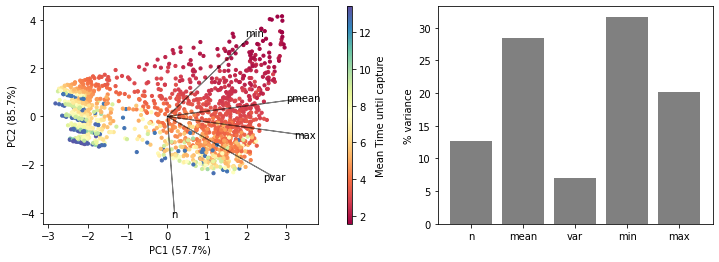

In [31]:
X=['n','mean','var','min','max']
Y=[12.712261,28.457873,6.972028,31.701471,20.156367] #From R


fig,[ax,cax,blank,hist] = plt.subplots(1,4, gridspec_kw={"width_ratios":[50,1,5,50]},figsize=(12,4))
blank.axis('off')
plt_pca_static(fig,ax,cax)
hist.bar(X,Y,color='grey')

hist.set_ylabel('% variance')
#plt.hist(finalDf['Mean Ttime'])

Text(0.5, 1.0, 'SpearmanrResult(correlation=-0.6886261304548797, pvalue=2.724231011328392e-246)')

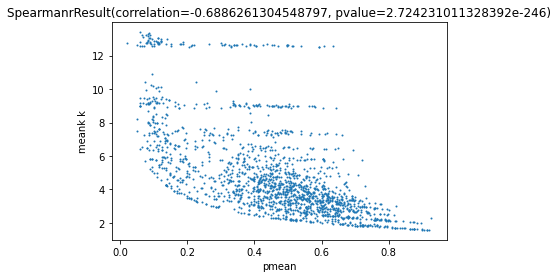

In [11]:
variable='pmean'

plt.scatter(finalDf[variable],finalDf['Mean Ttime'],s=1)
plt.xlabel(variable)
plt.ylabel('meank k')
plt.title(scp.stats.spearmanr(finalDf[variable],finalDf['Mean Ttime']))

Text(0.5, 1.0, 'SpearmanrResult(correlation=-0.9646051723241207, pvalue=0.0)')

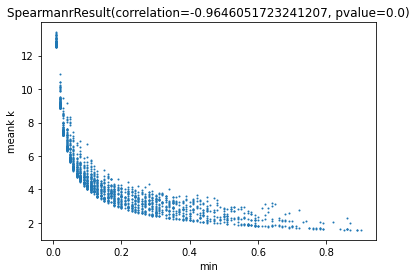

In [12]:
variable='min'

plt.scatter(finalDf[variable],finalDf['Mean Ttime'],s=1)
plt.xlabel(variable)
plt.ylabel('meank k')
plt.title(scp.stats.spearmanr(finalDf[variable],finalDf['Mean Ttime']))

Text(0.5, 1.0, 'SpearmanrResult(correlation=0.15051401808440512, pvalue=2.4830252080565057e-10)')

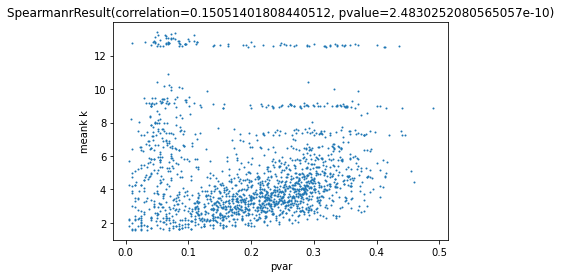

In [13]:
variable='pvar'

plt.scatter(finalDf[variable],finalDf['Mean Ttime'],s=1)
plt.xlabel(variable)
plt.ylabel('meank k')
plt.title(scp.stats.spearmanr(finalDf[variable],finalDf['Mean Ttime']))

Text(0.5, 1.0, 'SpearmanrResult(correlation=-0.3143933519105359, pvalue=1.8898478923413912e-41)')

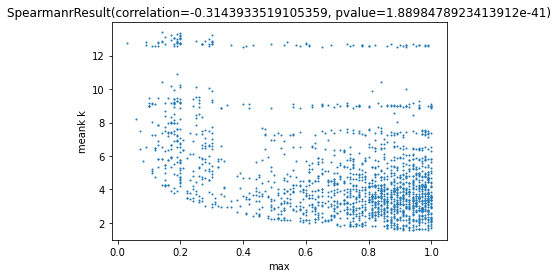

In [14]:
variable='max'

plt.scatter(finalDf[variable],finalDf['Mean Ttime'],s=1)
plt.xlabel(variable)
plt.ylabel('meank k')
plt.title(scp.stats.spearmanr(finalDf[variable],finalDf['Mean Ttime']))

Text(0.5, 1.0, 'SpearmanrResult(correlation=0.44590319198375716, pvalue=3.061288067599252e-86)')

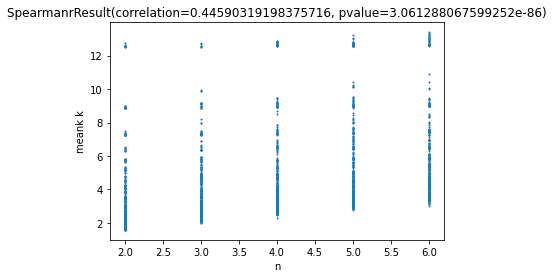

In [15]:
variable='n'

plt.scatter(finalDf[variable],finalDf['Mean Ttime'],s=1)
plt.xlabel(variable)
plt.ylabel('meank k')
plt.title(scp.stats.spearmanr(finalDf[variable],finalDf['Mean Ttime']))